In [13]:
%matplotlib inline
import os, sys, gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as tri
from collections import Counter
from scipy.special import factorial
import itertools
from math import comb
from scipy.stats import chi2
import dataframe_image as dfi
from datetime import timedelta

In [11]:
version = '1.0'
load_dir = '../data/human/{}'.format(version)
save_dir = load_dir
print(os.listdir(load_dir))
times = ['00:10:09', '00:07:53', '00:04:34', '00:03:06', '00:04:27',
'00:05:30', '00:02:22', '00:03:47', '00:03:29', '00:03:25',
'00:03:38', '00:05:20', '00:05:34', '00:03:00', '00:03:06',
'00:22:42', '00:02:58', '00:02:42', '00:04:10', '00:05:28',
'00:05:18', '00:04:22', '00:02:32', '00:03:11', '00:03:55',
'00:04:02', '00:06:34', '00:03:32', '00:05:52', '00:05:56']

print((str(timedelta(seconds=sum(map(lambda f: int(f[0])*3600 + int(f[1])*60 + int(f[2]), map(lambda f: f.split(':'), times)))/len(times)))))
print(sorted(times))

['.DS_Store', 'processed_data.p', 'participants.csv', 'html-button-response-filtered.csv', 'html-button-response.csv', 'survey-multi-select.csv', 'processed_data_summary.p', 'html-keyboard-response.csv']
0:05:05.133333
['00:02:22', '00:02:32', '00:02:42', '00:02:58', '00:03:00', '00:03:06', '00:03:06', '00:03:11', '00:03:25', '00:03:29', '00:03:32', '00:03:38', '00:03:47', '00:03:55', '00:04:02', '00:04:10', '00:04:22', '00:04:27', '00:04:34', '00:05:18', '00:05:20', '00:05:28', '00:05:30', '00:05:34', '00:05:52', '00:05:56', '00:06:34', '00:07:53', '00:10:09', '00:22:42']


# Data analysis
In this script, we apply classical and Bayesian approaches to determine whether the data provide significant evidence of deviations from independence between features and relations. We will either focus on the strong or weak MAX effect, or MAX and MIN effects together (both of these represent deviations). 

The data are presented below. (D-B) - (C-A) positive represents weak support for MAX, and Max indicates whether strong support was also found. Strong support for a participant implies weak support. 

In [26]:
fullDataDF = pd.read_pickle('{}/processed_data.p'.format(load_dir))
N = len(fullDataDF)
print('N is {}'.format(N))
#display(fullDataDF)

summary = pd.read_pickle('{}/processed_data_summary.p'.format(load_dir))

summary.loc['N_ind'] = summary.loc["N"] - summary.loc["N_max"] - summary.loc["N_min"]
dfi.export(summary, '{}/pilot_results.png'.format(save_dir))
display(summary.round(2))
summary.drop(labels=["Original"], axis="columns", inplace=True)
summary["Original"] = [6.4, 3.1, 5.8, 3.6, 1.1, 14, 3, 29, 12]
display(summary.round(2))

N is 28


[0209/141442.470036:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/z3/65sxpv5n3csdhfzm0ysx30940000gp/T/: Operation not permitted (1)
[0209/141442.471230:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0209/141442.472448:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/z3/65sxpv5n3csdhfzm0ysx30940000gp/T/: Operation not permitted (1)
[0209/141443.123603:INFO:headless_shell.cc(659)] Written to file /var/folders/z3/65sxpv5n3csdhfzm0ysx30940000gp/T/tmp1uteyp9e/temp.png.


,Original,Ours
A,5.8,5.43
B,3.4,1.61
C,5.2,4.59
D,3.6,2.16
(D-B)-(C-A),0.8,1.39
N_max,10.0,1.00
N_min,5.0,0.00
N,29.0,28.00
N_ind,14.0,27.00


,Ours,Original
A,5.43,6.4
B,1.61,3.1
C,4.59,5.8
D,2.16,3.6
(D-B)-(C-A),1.39,1.1
N_max,1.00,14.0
N_min,0.00,3.0
N,28.00,29.0
N_ind,27.00,12.0


Text(0, 0.5, 'Counts')

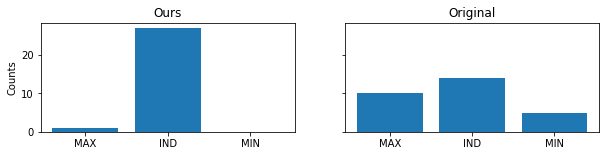

In [6]:

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 2))
ax[0].bar(['MAX', 'IND', 'MIN'], [summary["Ours"].loc["N_max"], summary["Ours"].loc["N_ind"], summary["Ours"].loc["N_min"]])
ax[1].bar(['MAX', 'IND', 'MIN'], [summary["Original"].loc["N_max"], summary["Original"].loc["N_ind"], summary["Original"].loc["N_min"]])
ax[0].set_title('Ours')
ax[1].set_title('Original')
ax[0].set_ylabel('Counts')

In [7]:
# Dirichlet plotting functions; from here http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])
def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

def draw_pdf_contours(ax, dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    ax.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    ax.axis('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.75**0.5)
    ax.axis('off')
    
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))


## Strong evidence 1: MAX vs MIN
Strong evidence to support dependence of features and relations comes from participants acting in logical consistency with the MAX or MIN effects.

MAX: SIM(D, T) > SIM(B, T) & SIM(A, T) > SIM (C, T) (Both trials)

MIN: SIM(D, T) < SIM(B, T) & SIM(A, T) < SIM (C, T) (Both trials)

The authors of the original work assess the strong effect as the number of participants who behave consistently with the MAX strategy over those behaving consistently with the MIN. This is a simple binomial test, with the assumption that random behaviour would lead to equal probabilities.

The (one-tailed) exact binomial test is straightforward to calculate. Recall that the probability of $h$ heads under the binomial distribution is:

$$
p(x=h) = {N \choose h}p^h(1-p)^{N-h}
$$

The binomial test then counts exactly how many outcomes are less or equally probable than ours under a null model. Setting our null model to $\pi_0=(1-\pi_0)=\frac{1}{2}$:

$$
p = \sum_{i=0}^h{N_{Max/Min} \choose i}\pi_0^i(1-\pi_0)^{N_{Max/Min}-i},
$$

Where $N_{Max/Min}$ is the number of participants showing one of the effects.

In [22]:
def binomial_probability(h, p, N):
    return comb(int(N), int(h)) * (p**h) * ((1-p)**(N-h))

def binomial_test(h, p, N_m):
    p_val = 0
    for i in np.arange(h, N_m+1): # number of maxes "heads"
        p_val += binomial_probability(i, p, N_m)
    return p_val

originalH = summary["Original"].loc["N_max"]
originalNM = originalH + summary["Original"].loc["N_min"]

ourH = summary["Ours"].loc["N_max"]
ourNM = ourH + summary["Ours"].loc["N_min"]

print("Binomial test for original data is {}; reported in study was 0.0156".format(binomial_test(originalH,
                                                                                                 0.5,
                                                                                                 originalNM
                                                                                                )))

print("Binomial test for our data is {}".format(binomial_test(ourH,
                                                              0.5,
                                                              ourNM
                                                             )))

15.0
15.0
Binomial test for original data is 0.15087890625; reported in study was 0.0156
1.0
1.0
Binomial test for our data is 0.5


## Strong evidence 2: Distribution of behaviours
Strong evidence to support dependence of features and relations comes from participants acting in logical consistency with the MAX or MIN effects.

MAX: SIM(D, T) > SIM(B, T) & SIM(A, T) > SIM (C, T) (Both trials)

MIN: SIM(D, T) < SIM(B, T) & SIM(A, T) < SIM (C, T) (Both trials)

The authors of the original work offer another assessment: the proportion

We can think about modeling this as a multinomial distribution, where we have N observations and three categories (MAX, INDEP, MIN).

Recall that the probability of a count vector under the multinomial distribution is:
$$
p({\bf x}) = N!\prod_{i=1}^k\frac{\pi_i^k}{x_i!}.
$$

The first question we can ask, is are there significantly more MAX and MIN responses than would be expected by chance? We can view "by chance" as meaning one of two things:

<ol>
    <li>Each guess is a chance event (uniform over 1-9) </li>
    <li>Each behaviour is a chance event (MAX, IND, MIN) </li>
</ol>

### Frequentist analysis
The basis of frequentist analysis will be to propose hypotheses in the form of parameters for the multinomial distribution, and test whether our data deviates significantly from these. We have the following hypotheses to test:

<ol>
    <li>The result of random guessing, uniform over the similarity ratings for each pair; </li>
    <li>The result of making judgements in accordance with feature-relation independence, smoothed (Laplace);</li>
    <li>As above, with free noise parameter (Dirichlet($\alpha, 1-2*\alpha, \alpha$)); </li>
    <li>The MLE parameters from the original trial;</li>
    <li>The MLE parameters;</li>
    <li>The posterior mode parameters (Dirichlet(1, 1, 1) as prior.)</li>
</ol>



<BarContainer object of 3 artists>

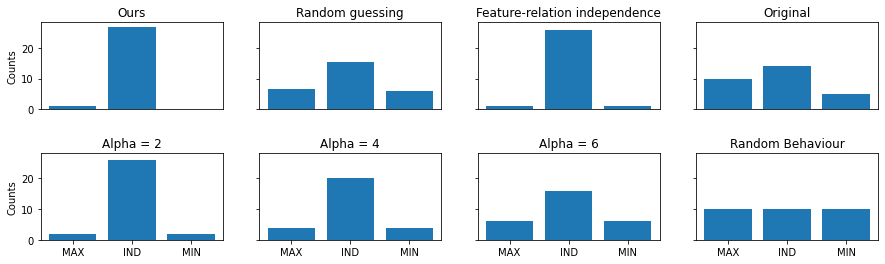

In [8]:
simulations = 100

def random_guess_distribution(N):
    """ This assumes people are guessing uniformly over 1-9 twice for each (target, base) pair."""
    results = {'MIN': 0, 'MAX': 0, 'IND': 0}
    
    for i in range(N):
        # average of two guesses
        guesses = np.mean(np.random.randint(low=0, high=10, size=(2, 4)), axis=0)
        
        if (guesses[3] - guesses[1] > 0) & (guesses[2] - guesses[0] < 0):
            results['MAX'] += 1
        elif (guesses[3] - guesses[1] < 0) & (guesses[2] - guesses[0] > 0):
            results['MIN'] += 1
        else:
            results['IND'] += 1
        
    return results

master_results = {'MIN': 0, 'MAX': 0, 'IND': 0}
for run in range(simulations):
    results = random_guess_distribution(N)
    master_results = Counter(master_results) + Counter(results)
master_results = {k: v / simulations for k, v in master_results.items()}

fig, ax = plt.subplots(2, 4, sharey=True, figsize=(15, 4))
ax[0][0].set_title('Ours')
ax[0][0].bar(['MAX', 'IND', 'MIN'], [summary["Ours"].loc["N_max"], summary["Ours"].loc["N_ind"], summary["Ours"].loc["N_min"]])

ax[0][1].set_title('Random guessing')
ax[0][1].bar(['MAX', 'IND', 'MIN'], [master_results['MAX'], master_results['IND'], master_results['MIN']])

ax[0][2].set_title('Feature-relation independence')
ax[0][2].bar(['MAX', 'IND', 'MIN'], [1, N-2, 1])

ax[0][3].set_title('Original')
ax[0][3].bar(['MAX', 'IND', 'MIN'], [summary["Original"].loc["N_max"], summary["Original"].loc["N_ind"], summary["Original"].loc["N_min"]])

for axs in ax[0]:
    axs.set_xticks([])

fig.subplots_adjust(hspace=0.5)
ax[0][0].set_ylabel('Counts')
ax[1][0].set_ylabel('Counts')

ax[1][0].set_title('Alpha = 2')
ax[1][0].bar(['MAX', 'IND', 'MIN'], [2, N-2, 2])

ax[1][1].set_title('Alpha = 4')
ax[1][1].bar(['MAX', 'IND', 'MIN'], [4, N-8, 4])

ax[1][2].set_title('Alpha = 6')
ax[1][2].bar(['MAX', 'IND', 'MIN'], [6, N-12, 6])

ax[1][3].set_title('Random Behaviour')
ax[1][3].bar(['MAX', 'IND', 'MIN'], [10, 10, 10])


#### Exact multinomial test
We can use the exact multinomial test to give a p-value for the data under each of these models. This is the "test of the null hypothesis that parameters of a multinomial distribution equal specified values." (Wikipedia)

Under a given model ($\theta = \{\pi_1, \pi_2, \pi_3\}; \sum_i\pi_i = 1, \forall i, \pi_i > 0.$), the probability of our count vector can be calculated as follows:

$$
p({\bf x}_0) = N!\prod_{i=1}^k\frac{\pi_i^k}{x_i!}.
$$

We are interested in "the probability of occurence of dataset observed, or less likely than that observed, if H0 true". This can be calculated as:

$$
p_{sig} = \sum_{{\bf y}: p({\bf y})\le p({\bf x}_0)}p({\bf y})
$$

The computationally exacting part of this test is to "figure out all the possible permutations in the values of each level that would be even less probable than the values in the sample." (https://rinterested.github.io/statistics/multinomial_exact.html)

The number of possible count vectors is ${N+k-1 \choose k-1}$. With $N\approx30$, this is around 400 vectors; we can give it a go.

In [ ]:
def multinomial_probability(counts, params):
    k = len(counts)
    N = sum(counts)
    return factorial(N) * np.prod(params**counts / factorial(counts))

testCounts = np.array([3, 2, 1])
testParams = np.array([0.2, 0.7, 0.1])
print(60*0.0008*0.49)
print(multinomial_probability(testCounts, testParams))

def generate_vectors(N, k):
    """A function that generates all possible count vectors. 
    This is the same as all ways of throwing N balls in k bins"""
    masks = np.identity(k, dtype=int)
    return itertools.combinations_with_replacement(masks, N)

o = generate_vectors(4, 2)
print([sum(c) for c in o])

def exact_multinomial_test(counts, params, upper_limit = 10**10):
    """Takes observed counts, model params, and iterator over all possible count vectors.
    Returns proportion of those vectors that are less probable; p-value."""
    N = int(sum(counts))
    k = int(len(counts))

    p_val = 0
    prob_to_beat = multinomial_probability(counts, params)
    combinations = comb(N+k-1, k-1)
    if combinations > upper_limit:
        print("not running {} combinations".format(combinations))
        return
    else:
        print("Running with {} combinations".format(combinations))
    
    vector_iterator = generate_vectors(N, k)
    
    for c in vector_iterator:
        tempCounts = sum(c)
        prob_temp = multinomial_probability(tempCounts, params)
        
        if prob_temp <= prob_to_beat:
            p_val += prob_temp
        
    return p_val

In [ ]:
# Define all models and test data against them
print(N)
print(comb(N+2, 2))
counts = np.array([summary["Ours"].loc["N_max"], summary["Ours"].loc["N_ind"], summary["Ours"].loc["N_min"]])

MLE = counts / N

randomGuessingMC = np.array([master_results['MAX'], master_results['IND'], master_results['MIN']]) / N
independenceLaplace = np.array([1, N-2, 1]) / N
originalMLE = np.array([summary["Original"].loc["N_max"], summary["Original"].loc["N_ind"], summary["Original"].loc["N_min"]]) / N
alpha2Model = np.array([2, N-4, 2]) / N
alpha4Model = np.array([4, N-8, 4]) / N
alpha6Model = np.array([6, N-12, 6]) / N
randomBehaviour = np.array([1/3, 1/3, 1/3])

models = {'Random Guessing': randomGuessingMC, "IND Laplace":independenceLaplace,
         'MLE': MLE, 'Original MLE': originalMLE,
         "alpha = 2": alpha2Model, "alpha4Model": alpha4Model, "alpha6Model": alpha6Model,
         "Random Behaviour": randomBehaviour}

for k, v in models.items():
    print()
    print(k)
    print(v)
    p_val_temp = exact_multinomial_test(counts, v)
    print("p value is {}".format(p_val_temp))
    


#### Likelihood ratio test
"An alternative hypothesis can be defined under which each value $\pi_i$ is replaced by the MLE" (Wikipedia):

$$
\hat{\pi}_i := \frac{x_i}{N}\\
p({\bf x})_A = N! \prod \frac{\hat{\pi}_i^{x_i}}{x_i!}
$$

"The natural logarithm of likelihood ratio between these probabilities is a statistic for the likelihood ratio test":

$$
-2\ln([\mathcal{L}\mathcal{R}]) = -2 \sum_{i=1}^k x_i \ln \frac{\pi_i}{\hat{\pi}_i}
$$

The constant factor is to make statistic asymptotically Chi-Squared, for convenience. We can then calculate the tail area probability by $1-CDF(\text{LRT statistic}, k-1)$. The MLE for the multinomial has k-1 degrees of freedom because of the sum to one constraint.

In [ ]:
def LRT_multinomial(counts, probs1, MLE):
    ratio = probs1 / MLE
    print(ratio)
    return -2*(np.sum(counts * np.log(ratio)))

for k, v in models.items():
    print()
    print(k)
    print(v)
    chi = LRT_multinomial(counts, v, MLE)
    print("Chi sum value is {}".format(chi))
    
    p_val = 1 - chi2.cdf(chi, 2)
    print("Approximate p value is {}".format(p_val))

#### More realistic null model
Really, the model we are interested in testing our data against is that some combination of people guess, and some follow feature-relation independence (our current model's prediction). This can be thought of in a couple of ways, but the easiest analysis is in the frequentist setting. Here, a noise parameter, $\alpha$, can be used to interpolate between these two models, giving a one-parameter model that would be contained within the parameter space of our full MLE model.

That is, we model the data using the following multinomial distribution (with $c$ as a normalizing constant):

$$
p({\bf x}) = c\cdot\alpha^{x_1}\cdot(1-2\cdot\alpha)^{x_2}\cdot\alpha^{x_3} 
$$

We can derive the MLE for $\alpha$ as follows. Taking logs and dropping constants, the expression above becomes:

$$
\log(p({\bf x})) = (x_1+x_3)\cdot\log\alpha + x_2\log(1-2\cdot\alpha) 
$$

Taking derviatives, we obtain:

$$
\frac{d}{d \alpha}\log(p({\bf x})) = \frac{x_1+x_3}{\alpha} + \frac{x_2}{(1-2\cdot\alpha)} 
$$

We can set this to zero, and rearrange to find any maxima:

$$
x_2\cdot\alpha  = (x_1+x_3)\cdot(1-2\cdot\alpha) = x_1\cdot(1-2\cdot\alpha) + x_3\cdot(1-2\cdot\alpha) = x_1 - 2\cdot\alpha \cdot x_1 + x_3 -2\cdot\alpha\cdot x_3
$$

$$
\alpha \cdot (x_2 + 2x_1 + 2x_3) =  x_1+x_3
$$

$$
\alpha = \frac{x_1+x_3}{x_2 + 2x_1 + 2x_3},
$$

which makes intuitive sense. 

In [ ]:
def find_MLE(x_1, x_2, x_3):
    return (x_1 + x_3) / (x_2 + 2*x_1 + 2*x_3)

alpha = find_MLE(summary["Ours"].loc["N_max"], summary["Ours"].loc["N_ind"], summary["Ours"].loc["N_min"])
alpha_M = alpha * N
alpha_I = (1-2*alpha)*N
alpha_m = alpha_M
alphaModel = [alpha, 1-2*alpha, alpha]
print('MLE of alpha is: {}'.format(alpha))
print('P-value is {}'.format(exact_multinomial_test(counts, alphaModel)))

fig, ax = plt.subplots(1, 4, sharey=True, figsize=(15, 4))
ax[0].set_title('Ours')
ax[0].bar(['MAX', 'IND', 'MIN'], [summary["Ours"].loc["N_max"], summary["Ours"].loc["N_ind"], summary["Ours"].loc["N_min"]])

ax[1].set_title('Random guessing')
ax[1].bar(['MAX', 'IND', 'MIN'], [master_results['MAX'], master_results['IND'], master_results['MIN']])

ax[2].set_title('Feature-relation independence')
ax[2].bar(['MAX', 'IND', 'MIN'], [0, N, 0])

ax[3].set_title('MLE alpha')
ax[3].bar(['MAX', 'IND', 'MIN'], [alpha_M, alpha_I, alpha_m])

ax[0].set_ylabel('Counts')



### Bayesian analysis
In the Bayesian setting, a basic null model for our data is to assume that all N observations come from the independence class, and incorporate our uncertainty in a uniform (Dirichlet) prior. This gives the following posterior.

$\theta^{null} \, \sim \, \text{Dirichlet}(1, N+1, 1).$

There are a number of ways we could go about testing whether our data deviate from the numbers expected under a null model.

In [ ]:
prior = np.array([1, 1, 1])
null = np.array([0, N, 0]) + prior
actual = np.array([summary["Ours"].loc["N_max"], 
                  summary["Ours"].loc["N_ind"], summary["Ours"].loc["N_max"]]) + prior
previous = np.array([summary["Original"].loc["N_max"], 
                     summary["Original"].loc["N_ind"], summary["Original"].loc["N_max"]])

fig, ax = plt.subplots(1, 4, figsize = (15, 5))
draw_pdf_contours(ax[0], Dirichlet(prior))
draw_pdf_contours(ax[1], Dirichlet(null))
draw_pdf_contours(ax[2], Dirichlet(actual))
draw_pdf_contours(ax[3], Dirichlet(previous))
ax[0].set_title('Prior')
ax[1].set_title('Null posterior')
ax[2].set_title('Our posterior')
ax[3].set_title('Previous study posterior')

#### Tail probabilities (Quoted from BDA3, pg 146)
"We can evaluate the fit of the null and previous study posterior predictive distribution our data by considering the Bayesian {$p$}-value---the probability that data replicated from the posterior could be more extreme than the observed data, as measured by the test quantity":

${p}_B = \text{Pr}(T(y^{rep}, \theta)) \ge T(y,\theta)|y),$

"where the probability is taken over the posterior distribution of $\theta$ and the posterior predictive distribution of $y^{rep}$. This is equivalent to the joint distribution, $p(\theta, y^{rep}|y)$":

$p_B = \int \int I_{T(y^{rep},\theta) \ge T(y, \theta)}p(y^{rep}|\theta)p(\theta|y)dy^{rep}d\theta$.

N.B. A test quantity $T(\theta, y)$ generalizes the classical idea of a test statistic, $T(y)$; the difference being the quantity is also a function of the parameter values, $\theta$.

The first test quantity is the proportion of subjects exhibiting non-independence, $\frac{N_{max} + N_{min}}{N}$.

We can approximate this interval using Monte Carlo to first draw a parameter, $\tilde{\theta}$, then an artificial sample $y^{rep}|\theta$.

In [ ]:
S = 1000

def t(data):
    return (data[0] + data[-1]) / np.sum(data)

t_obs = t(actual - prior)
print('t_obs is: {}'.format(t_obs))

def tail_probs(model, t_obs, N, S=10000):
    scores = 0
    for s in np.arange(S):
        params = np.random.dirichlet(model)
        rep = np.random.multinomial(N, params)
        t_rep = t(rep)
        if t_rep > t_obs:
            scores += 1
    return scores/S
 
modelNames = ['prior', 'null', 'previous', 'alpha']
models = [prior, null, previous, alphaModel]

for model_name, model in zip(modelNames, models):
    p = tail_probs(model, t_obs, N)
    print('For model <{}>, Bayesian p-value is {}.'.format(model_name, p))

#### Bayes factors
We can also compare models---in this case, the realistic null model and the full Dirichlet---by Bayesian model selection / comparison. This involves calculating or approximating the model evidence term, $p(D|M) = \int_{\theta'}p(D|\theta', M)p(\theta'|M)$.

Adding a prior, our realistic null model is as follows:

$$
p(D|\alpha) \sim \text{Multinomial}(N, \alpha, 1-2\alpha, \alpha)\\
p(\alpha) \sim \text{Uniform}(0, 0.5)
$$

We wish to test whether the data are better accounted for by a unconstrained Dirichlet-Multinomial model. For instance, the null model cannot account for the asymmetry between MAX and MIN responses seen in our data and the original study. 

We can specify this model as follows:

$$
p(D|\alpha) \sim \text{Multinomial}(N, {\bf \theta})\\
p({\bf \theta}) \sim \text{Dirichlet}(1, 1, 1)
$$

Because the parameter space is small, it is likely we can reasonably approximate this integral using simple Monte Carlo, as follows:

$$
p(D|M) = \int_{\theta'}p(D|\theta', M)p(\theta'|M) \approx \frac{1}{J}\sum_{j=1}^J p(D|\theta^{(j)})\\
\theta^{(j)} \sim p(\theta) 
$$

Assuming equal values for priors $p(M)$, we can compare the two models by the ratio of their evidence (Bayes Factor):

$$
\text{BF} = \frac{p(D|Full)}{p(D|Null)}
$$

In [ ]:
def evidence_MC(counts, param_fn, hyperparams, likelihood_fn, samples):
    l = 0
    for j in np.arange(samples):
        params = param_fn(hyperparams)
        l += likelihood_fn(counts, params)
    return l / samples

def theta_fn(dirichletParams):
    """Dirichlet params must have k length"""
    theta = np.random.dirichlet(dirichletParams, size=None)
    return theta

def alpha_fn(alphaParams):
    """Alpha params must have 2 length"""
    alpha = np.random.uniform(low=alphaParams[0], high=alphaParams[1])
    return alpha

def return_alpha_theta(alphaParams):
    alpha = alpha_fn(alphaParams)
    assert 0 <= alpha <= 0.5, "alpha value wrong ({}): should be between 0 and 0.5".format(alpha)
    dP = np.array([alpha, 1-(2*alpha), alpha])
    return theta_fn(dP)

In [ ]:
J = 10000
MFull = evidence_MC(counts, theta_fn, [1, 1, 1], multinomial_probability, samples=J)
MNull = evidence_MC(counts, return_alpha_theta, [0, 0.5], multinomial_probability, samples=J)
print('Bayes Factor is: {}'.format(MFull / MNull))

## Weak Evidence 1: (D - B) - (C - A) greater than zero
The authors of the original work mainly analyze differences of means. Although I have misgivings about this (see below), we can reconduct their original analysis.

First, the authors examine whether (D - B) - (C - A) is positive and significantly greater than zero for each and all datasets. As we only have one, we will concentrate there. Although not explicitly stated, we assume they use a t-test for this.

Recall that Student's t-test


"The reason that this is only weak support for MAX is that it falls short
of the ordinal effect that was required for MAX support in Experiments 1
and 2. The above results could be explained without invoking MAX; for
example, it could be that subject’s similarity judgments are more sensitive
in the 5-6 range than they are in the 67 range. That is, the rating scale
may not satisfy the assumptions of an interval scale. So, the difference
between 5.6 and 5.8 may be psychologically equal to the difference between
6.0 and 6.8."